# Clustering by power consumption

We got this dataset with over 2M entrys about eletric power consumption inside a single household, and we must find the best way to cluster those results.
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [9]:
dataset = pd.read_csv('data/household_power_consumption.txt', delimiter = ';', low_memory = False)

dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


### Data exploration

In [10]:
# First, we check the shape of the dataset:
dataset.shape

(2075259, 9)

In [11]:
# Now let's look for NA values
dataset[dataset.isna().any(axis=1)]

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN
19724,30/12/2006,10:08:00,?,?,?,?,?,?,NaN
19725,30/12/2006,10:09:00,?,?,?,?,?,?,NaN
41832,14/1/2007,18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...,...,...
1990185,28/9/2010,19:09:00,?,?,?,?,?,?,NaN
1990186,28/9/2010,19:10:00,?,?,?,?,?,?,NaN
1990187,28/9/2010,19:11:00,?,?,?,?,?,?,NaN
1990188,28/9/2010,19:12:00,?,?,?,?,?,?,NaN


In [12]:
# So we got around 26K missing values, which translates to circa 1.25% of the total data. I could fill those values with the mean or median, but since we still have a pretty solid amount of data, we can just drop them.
dataset2 = dataset.dropna()

In [13]:
# We'll get a 1% sample of the data so we can use it for training purposes. 
sample = dataset2.sample(frac=0.01, random_state=42).drop(columns=['Date', 'Time'])

#To do: In the future, would be interesting to train the model with different samples and compare the results.

In [14]:
# Now we can use PCA to reduce the dimensionality, the result will be the training dataset.
sample_array = sample.values
train_data = PCA(n_components=2).fit_transform(sample_array)

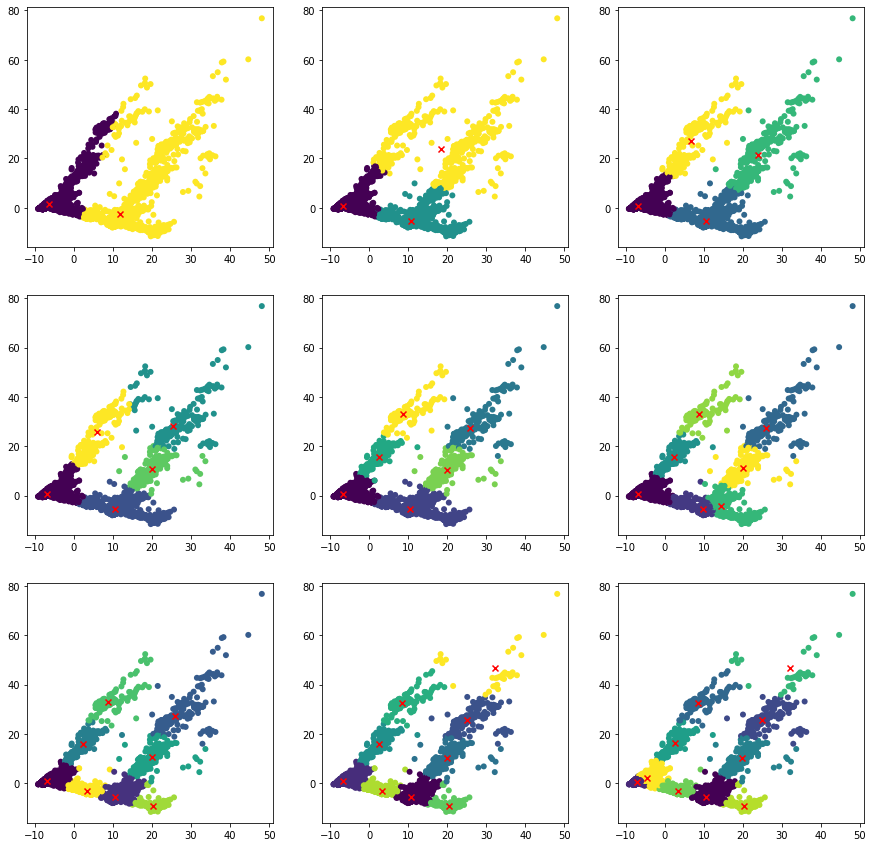

In [19]:
# We can now train multiple models testing different K values. We will also plot the clusters and their centroids, and save each model inertia and silhouette values for further analysis.
Ks = range(2, 11)

inertia = []
silhouette = []

plt.figure(figsize=[15,15])

for K in Ks:
    kmean = KMeans(n_clusters=K, random_state=42)
    modelo = kmean.fit(train_data)
    #metricas.append({'K':K, 'inertia':modelo.inertia_, 'silhouette':silhouette_score(train_data, modelo.labels_)})
    inertia.append(modelo.inertia_)
    silhouette.append(silhouette_score(train_data, modelo.labels_))
    res = modelo.predict(train_data)

    plt.subplot(3, 3, K-1)
    plt.scatter(train_data[:,0], train_data[:,1], c = res, edgecolors= 'none')
    plt.scatter(modelo.cluster_centers_[:,0], modelo.cluster_centers_[:,1], marker = 'x', c='r')
    plt.title(f'Clustering with {K} groups')

plt.show()

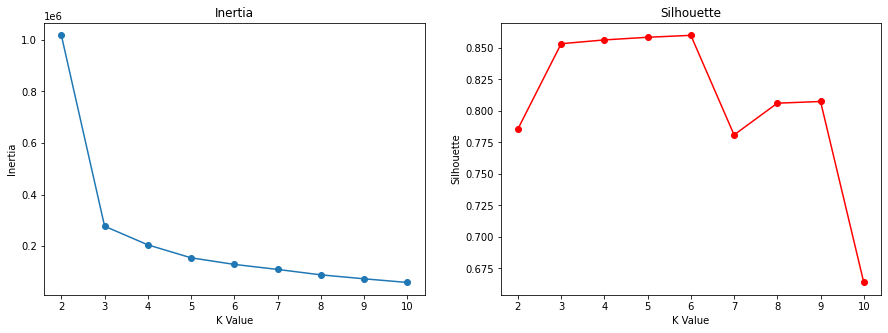

In [20]:
# Using the Inertia and Silhouette values we saved, we can plot those values and choose the best K value.

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Ks, inertia, 'o-')
plt.xlabel('K Value')
plt.ylabel('Inertia')
plt.title('Inertia')

plt.subplot(1,2,2)
plt.plot(Ks, silhouette, 'o-', c='r')
plt.xlabel('K Value')
plt.ylabel('Silhouette')
plt.title('Silhouette')

plt.show()

In [26]:
# The model with 6 clusters presented the best results, so we can move ahead and create and train the model.

kmeans_6 = KMeans(n_clusters=6, random_state=42)
model_with_6_clusters = kmeans_6.fit(train_data)
trained_data_clusters = model_with_6_clusters.predict(train_data)


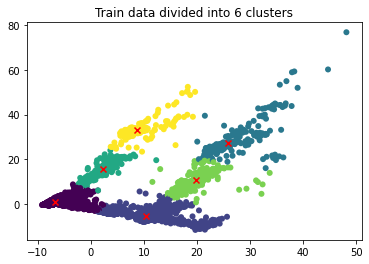

In [27]:
plt.scatter(train_data[:,0], train_data[:,1], c = trained_data_clusters, edgecolors= 'none')
plt.scatter(model_with_6_clusters.cluster_centers_[:,0], model_with_6_clusters.cluster_centers_[:,1], marker = 'x', c='r')
plt.title('Train data divided into 6 classes')
plt.show()

In [28]:
# Let's add the class to the sample dataframe, and get the mean global active power for each cluster.

sample['class'] = trained_data_clusters
mean_table = sample[['Global_active_power','class']]
mean_table['Global_active_power'] = mean_table['Global_active_power'].astype('float')
mean_table.groupby('class').mean()

,Global_active_power
class,
0,0.518159
1,1.779762
2,4.614898
3,2.478909
4,3.774620
5,3.503943
